In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import json
import argparse
import copy

import h5py

import torch

from matplotlib.colors import LogNorm

from scipy.ndimage import gaussian_filter

from lim_mock_generator.utils.power import compute_power, compute_cylindrical_power

from astropy.cosmology import Planck18 as cosmo
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=67.74, Om0=0.3089)
hlittle = cosmo.H0.value / 100

from astropy import units as u

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def my_savefig(fsave):
    if fsave is not None:
        plt.tight_layout()
        plt.savefig(fsave, dpi=300)
        print("Saved figure to", fsave)

def arcsec_to_cMpc(l_arcsec, z, with_hlittle=True):
    l_rad = l_arcsec * u.arcsec / u.radian
    l_cMpc = ( cosmo.comoving_transverse_distance(z) * l_rad ).to(u.Mpc)
    if with_hlittle:
         return l_cMpc.value * cosmo.h
    else:
        return l_cMpc.value 

def freq_to_comdis(nu_obs, nu_rest, with_hlittle=True):
    z = nu_rest / nu_obs - 1
    if z < 0:
        print("Error: z < 0")
        sys.exit(1)

    d =  cosmo.comoving_distance(z).to(u.Mpc)
    if with_hlittle:
        return d.value * cosmo.h
    else:
        return d.value
    
def load_data(fname, ix=0, iy=0, iz=0, nx=None, ny=None, nz=None, dataname="intensity"):
    print("Load {}".format(fname))
    with h5py.File(f"{fname}", "r") as f:
        intensity = f[dataname][:]
        header = {key: f.attrs[key] for key in f.attrs}

    if nx is None:
        nx = intensity.shape[0]
    if ny is None:
        ny = intensity.shape[1]
    if nz is None:
        nz = intensity.shape[2]
    intensity = intensity[ix:ix+nx, ix:ix+ny, ix:ix+nz]
    return intensity, header


In [4]:
### Load data
model_name = "transformer1"

snapshot_number = 38
snapshot_number = 33
base_dir = "../scripts/generated_data"
prefix_list = [ "group.{:d}".format(snapshot_number), 
               "subgroup.{:d}".format(snapshot_number), 
               "group.{:d}.{}".format(snapshot_number, model_name), 
               "pinocchio.run2.{}".format(model_name), 
               "pinocchio.run2.{}.mass_corrected".format(model_name) 
            ]

titles = ["TNG Halos", "TNG Subhalos", "Generated", "Pinocchio", "Pinocchio (Mass Corrected)"]

titles_rsd = [ f"{t} with RSD" for t in titles ]
data_list = []
data_rsd_list = []
cat_list = []
cat_rsd_list = []

header_list = []
header_rsd_list = []   
for p in prefix_list:
    fname = "{}/{}.h5".format(base_dir, p)
    intensity, header = load_data(fname, dataname="intensity0")
    data_list.append(intensity)
    header_list.append(header)

    intensity, header = load_data(fname, dataname="intensity1")
    
    data_rsd_list.append(intensity)
    header_rsd_list.append(header)

    path = "{}/{}.cat.txt".format(base_dir, p)
    print(path)
    if os.path.exists(path):
        cat = np.loadtxt(path)
        cat_list.append(cat)
    path = "{}/{}.rsd.cat.txt".format(base_dir, p)
    if os.path.exists(path):
        cat_rsd = np.loadtxt(path)
        cat_rsd_list.append(cat_rsd)


diff = [ d - d_rsd for d, d_rsd in zip(data_list, data_rsd_list) ]

Load ../scripts/generated_data/group.33.h5
Load ../scripts/generated_data/group.33.h5
../scripts/generated_data/group.33.cat.txt
Load ../scripts/generated_data/subgroup.33.h5


Load ../scripts/generated_data/subgroup.33.h5
../scripts/generated_data/subgroup.33.cat.txt
Load ../scripts/generated_data/group.33.transformer1.h5
Load ../scripts/generated_data/group.33.transformer1.h5
../scripts/generated_data/group.33.transformer1.cat.txt
Load ../scripts/generated_data/pinocchio.run2.transformer1.h5
Load ../scripts/generated_data/pinocchio.run2.transformer1.h5
../scripts/generated_data/pinocchio.run2.transformer1.cat.txt
Load ../scripts/generated_data/pinocchio.run2.transformer1.mass_corrected.h5
Load ../scripts/generated_data/pinocchio.run2.transformer1.mass_corrected.h5
../scripts/generated_data/pinocchio.run2.transformer1.mass_corrected.cat.txt


TNG Halos 49510810.46137025


TNG Subhalos 49510810.46137025
Generated 49510810.46137025
Saved figure to ../scripts/generated_data/figures/intensity_maps.png
TNG Halos with RSD 49510810.46137025
TNG Subhalos with RSD 49510810.46137025
Generated with RSD 49510810.46137025
Saved figure to ../scripts/generated_data/figures/intensity_maps_rsd.png
TNG Halos 49510810.46137025
TNG Subhalos 49510810.46137025
Generated 49510810.46137025
Saved figure to ../scripts/generated_data/figures/intensity_maps_diff.png


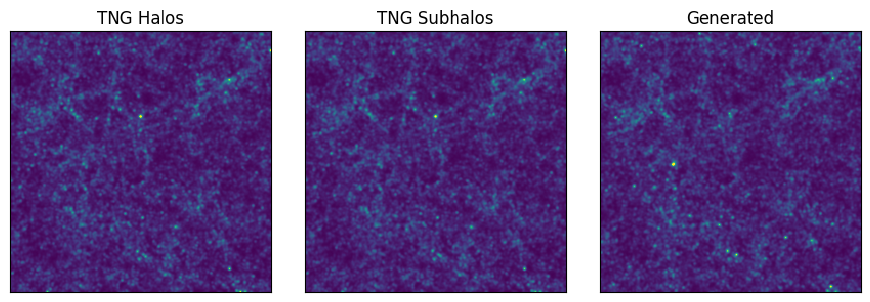

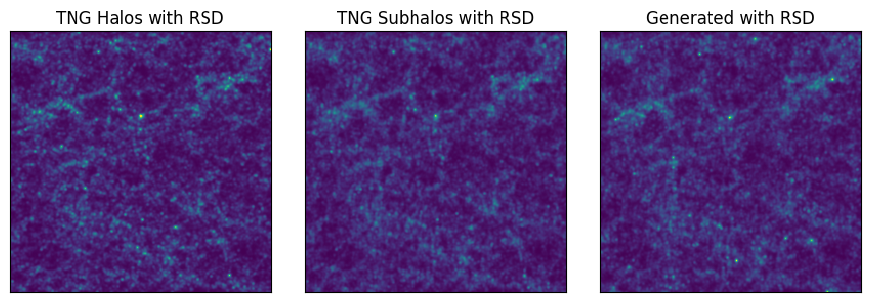

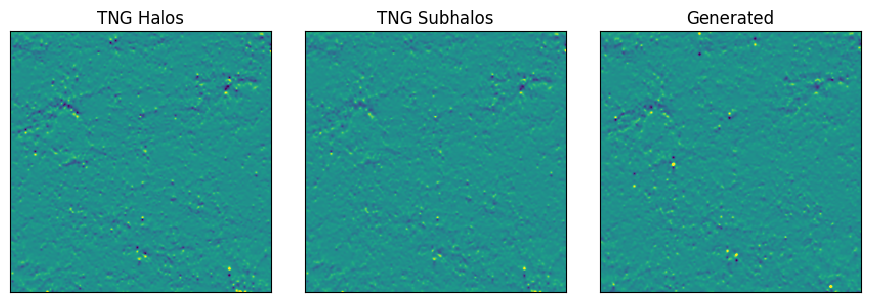

In [5]:
def show_images(data_list, titles, fsave=None, vmin=None, vmax=None, norm=None, nx=-1, ny=-1, nz=-1, sigma=1):

    plt.figure(figsize=(len(data_list) * 3, 3))
    for i, d in enumerate(data_list):        
        image = d[:nx, :ny, :nz].sum(axis=1)
        image = gaussian_filter(image, sigma=sigma)

        plt.subplot(1, len(data_list), i+1)
        plt.title(titles[i])
        plt.imshow(image.T, origin="lower", interpolation="none", vmin=vmin, vmax=vmax, norm=norm)

        plt.xticks([])
        plt.yticks([])
        #plt.colorbar()

        print(titles[i], np.sum(intensity))
        
    my_savefig(fsave)
        
fsave = "{}/figures/intensity_maps.png".format(base_dir)
show_images(data_list[:3], titles, fsave=fsave, vmin=0, vmax=200)
#show_images(fname_list, titles, fsave, norm=LogNorm(vmin=0.1, vmax=100))

fsave = "{}/figures/intensity_maps_rsd.png".format(base_dir)
show_images(data_rsd_list[:3], titles_rsd, fsave=fsave, vmin=0, vmax=200)
#show_images(fname_list, titles, fsave, norm=LogNorm(vmin=0.1, vmax=100))

fsave = "{}/figures/intensity_maps_diff.png".format(base_dir)
show_images(diff[:3], titles, fsave=fsave, vmin=-100, vmax=100)


Saved figure to ./output_test/figures/intensity_maps_pinocchio.png
Saved figure to ./output_test/figures/intensity_maps_pinocchio_rsd.png


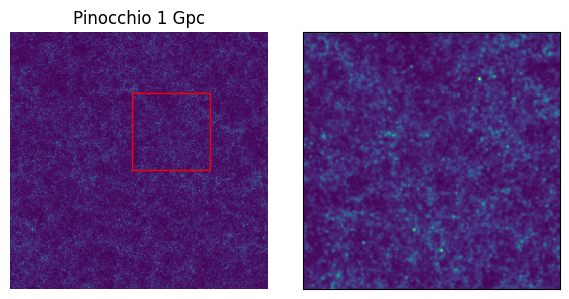

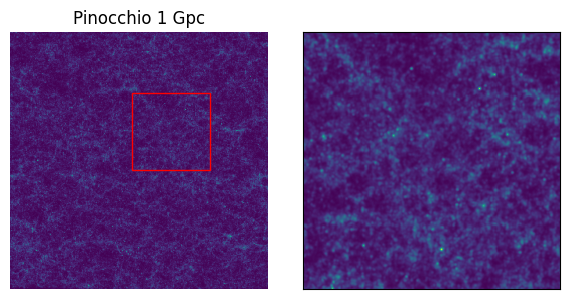

In [3]:
fsave_list = ["{}/figures/intensity_maps_pinocchio.png".format(base_dir), 
         "{}/figures/intensity_maps_pinocchio_rsd.png".format(base_dir)]

for i, d in enumerate([data_list[-1], data_rsd_list[-1]]):
    image = d[:,:256,:].sum(axis=1)
    image = gaussian_filter(image, sigma=1)
    image = image.T # / 1.2

    x0, y0 = 400, 200  # ズーム範囲の左上 (x, y)
    zoom_size = 256
    zoom = image[y0:y0+zoom_size, x0:x0+zoom_size]

    fig, axes = plt.subplots(1, 2, figsize=(6, 3))

    axes[0].imshow(image, vmin=0, vmax=300, interpolation="none")
    axes[0].set_title("Pinocchio 1 Gpc")
    axes[0].add_patch(plt.Rectangle((x0, y0), zoom_size, zoom_size, edgecolor='red', facecolor='none', linewidth=1))
    axes[0].set_aspect('equal')
    axes[0].axis('off')

    axes[1].imshow(zoom, vmin=0, vmax=200, interpolation="none")
    #axes[1].set_title("Zoom up")
    #axes[1].add_patch(plt.Rectangle((0, 0), zoom_size, zoom_size, edgecolor='red', facecolor='none', linewidth=3, zorder=10))
    #for spine in axes[1].spines.values():
    #    spine.set_edgecolor('red')
    #    spine.set_linewidth(1) 
    axes[1].set_aspect('equal')
    axes[1].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    my_savefig(fsave_list[i])


32698
34882
34766


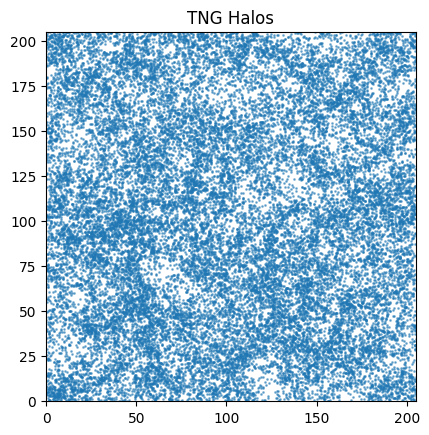

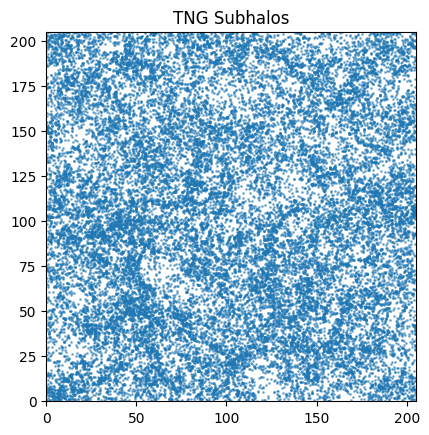

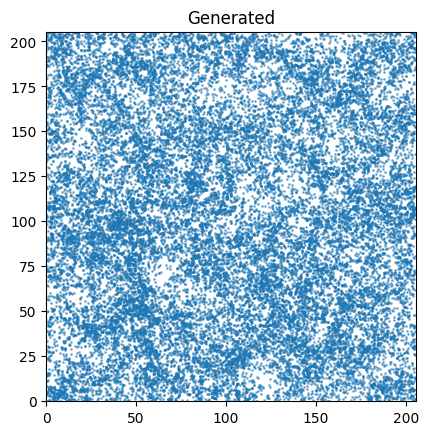

In [38]:
for i, cat in enumerate(cat_list):
    plt.figure()
    plt.title(titles[i])
    
    x = cat[:, 0]
    y = cat[:, 1]
    z = cat[:, 2]

    plt.scatter(x, y, s=1, label=titles[i], alpha=0.5)
    print(len(x))

    plt.xlim(0, x.max())
    plt.ylim(0, y.max())
    ax = plt.gca()
    ax.set_aspect('equal')

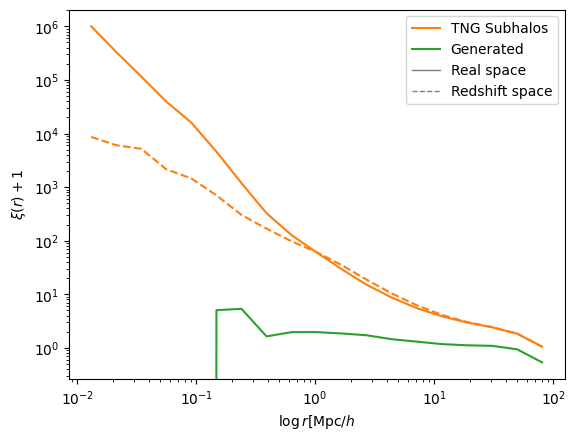

In [39]:
import numpy as np
from scipy.spatial import cKDTree

import numpy as np
from scipy.spatial import cKDTree

def two_point_cf(points, rbin, boxsize):

    N = points.shape[0]

    tree = cKDTree(points)
    pairs = tree.query_pairs(rbin[-1], output_type='ndarray')
    dists = np.linalg.norm(points[pairs[:, 0]] - points[pairs[:, 1]], axis=1)
    DD, _ = np.histogram(dists, bins=rbin)

    shell_volume = (rbin[1:]**3 - rbin[:-1]**3)
    total_volume = boxsize**3
    total_pairs = N * (N - 1) / 2
    RR = total_pairs * shell_volume / total_volume

    RR_safe = np.where(RR == 0, 1e-10, RR)
    eta = DD / RR_safe
    xi = eta - 1
    return xi

bins = np.logspace(-2, 2, 20)
bin_values = 0.5 * (bins[1:] + bins[:-1])

plt.figure(6, 4.5)

for i, cat in enumerate(cat_list):
    if i == 0:
        continue
    corr = two_point_cf(cat, bins, boxsize=205)
    plt.plot(bin_values, corr, color=colors[i], label=titles[i])

labels = ["RSD"] + [None] * 10
for i, cat in enumerate(cat_rsd_list):
    if i == 0:
        continue
    corr = two_point_cf(cat, bins, boxsize=205)
    plt.plot(bin_values, corr, color=colors[i], ls="--", label=labels[i])

plt.xscale("log")
plt.yscale("log")

xlim = plt.xlim()
ylim = plt.ylim()
plt.plot([0, 1], [ylim[0]*0.1, ylim[0]*0.1], color="gray", ls="solid", lw=1, label="Real space")
plt.plot([0, 1], [ylim[0]*0.1, ylim[0]*0.1], color="gray", ls="dashed", lw=1, label="Redshift space")
plt.xlim(xlim)
plt.ylim(ylim)


plt.xlabel(r"$\log r [{\rm Mpc}/h$")
plt.ylabel(r"$\xi(r) + 1$")    
plt.legend(frameon=False, ncol=2)


In [3]:
k_list = []
power_list = []
for data, header in zip(data_list, header_list):

    boxsize = header["boxsize"] / hlittle
    power, k, var = compute_power(data, boxlength=boxsize, log_bins=True)

    k_values = 0.5 * (k[1:] + k[:-1])
    power_list.append(power)
    k_list.append(k_values)

power_rsd_list = []
for data, header in zip(data_rsd_list, header_rsd_list):
    boxsize = header["boxsize"] / hlittle
    power, k, var = compute_power(data, boxlength=boxsize, log_bins=True)

    k_values = 0.5 * (k[1:] + k[:-1])
    power_rsd_list.append(power)
    k_list.append(k_values)

/mnt/data/moriwaki/LIM_mock/power.py:73: UserWarning: One or more radial bins had no cell within it. Use a smaller nbins.
  warnings.warn("One or more radial bins had no cell within it. Use a smaller nbins.")
/mnt/data/moriwaki/LIM_mock/power.py:79: RuntimeWarning: invalid value encountered in divide
  mean = np.bincount(indx, weights=np.real(field.flatten()), minlength=len(bins)+1)[1:-1] / sumweights


Saved figure to output_test/figures/power_spectrum.pdf


/mnt/data/moriwaki/LIM_mock/power.py:73: UserWarning: One or more radial bins had no cell within it. Use a smaller nbins.
  warnings.warn("One or more radial bins had no cell within it. Use a smaller nbins.")
/mnt/data/moriwaki/LIM_mock/power.py:79: RuntimeWarning: invalid value encountered in divide
  mean = np.bincount(indx, weights=np.real(field.flatten()), minlength=len(bins)+1)[1:-1] / sumweights


Saved figure to output_test/figures/power_spectrum_pinocchio.pdf


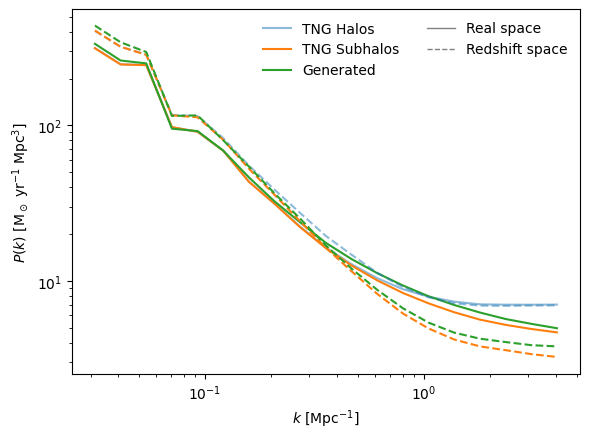

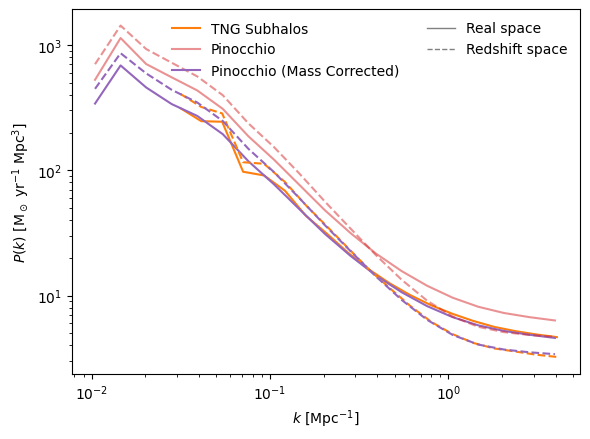

In [4]:
### Power spectrum  
def plot_power(k_list, power_list, header_list, titles=None, ls=None, color=None, zorder=0, alpha=None, id_list=None):
    ndata = len(data_list)
    if not isinstance(titles, list):
        titles = [titles] * len(data_list)
    if not isinstance(ls, list):
        ls = [ls] * len(data_list)
    if not isinstance(color, list):
        color = [color] * len(data_list)
    if not isinstance(zorder, list):
        zorder = [zorder] * len(data_list)
    if not isinstance(alpha, list):
        alpha = [alpha] * len(data_list)
    if id_list is None:
        id_list = range(len(data_list))

    for count, i in enumerate(id_list):
        k_values = k_list[i]
        power = power_list[i]
        plt.plot(k_values[1:], power[1:], label=titles[i], ls=ls[i], color=color[i], zorder=zorder[i], alpha=alpha[i])
        #plt.errorbar(k_values, power, yerr=np.sqrt(var), fmt="o")

def compare_power(id_list, fsave):

    plt.figure(figsize=(6, 4.5))
    alpha = [0.5, 1, 1, 0.5, 1]
    
    plot_power(k_list, power_list, header_list, titles, ls="solid", color=colors, id_list=id_list, alpha=alpha)
    plot_power(k_list, power_rsd_list, header_rsd_list, ls="dashed", color=colors, id_list=id_list, alpha=alpha)
    
    plt.xlabel(r"$k \ [\rm Mpc^{-1}]$")
    plt.ylabel(r"$P(k)\ [{\rm M_\odot\  yr^{-1} \  Mpc^3}]$")
    plt.yscale("log")
    plt.xscale("log")

    xlim = plt.xlim()
    ylim = plt.ylim()

    plt.plot([0, 1], [ylim[0]*0.1, ylim[0]*0.1], color="gray", ls="solid", lw=1, label="Real space")
    plt.plot([0, 1], [ylim[0]*0.1, ylim[0]*0.1], color="gray", ls="dashed", lw=1, label="Redshift space")
    plt.xlim(xlim)
    plt.ylim(ylim)
    
    plt.legend(frameon=False, ncol=2)
    my_savefig(fsave)

fsave = "output_test/figures/power_spectrum.pdf"
compare_power([0, 1, 2], fsave=fsave)

fsave = "output_test/figures/power_spectrum_pinocchio.pdf"
compare_power([1, 3, 4], fsave=fsave)


/tmp/ipykernel_216660/1030333777.py:28: UserWarning: The following kwargs were not used by contour: 'ls'
  plt.contour(X, Y, power2d, levels=[1, 1.5, 2, 3, 4], colors="k", ls="dashed", alpha=0.5)


[0.03064968 0.04789717 0.07485033 0.11697083 0.18279379 0.28565727
 0.44640509 0.69761047 1.09017657 1.70365126 2.66234636 4.16052762
 6.50177991] [0.03064968 0.04789717 0.07485033 0.11697083 0.18279379 0.28565727
 0.44640509 0.69761047 1.09017657 1.70365126 2.66234636 4.16052762
 6.50177991]
[0.03064968 0.04789717 0.07485033 0.11697083 0.18279379 0.28565727
 0.44640509 0.69761047 1.09017657 1.70365126 2.66234636 4.16052762
 6.50177991] [0.03064968 0.04789717 0.07485033 0.11697083 0.18279379 0.28565727
 0.44640509 0.69761047 1.09017657 1.70365126 2.66234636 4.16052762
 6.50177991]
[0.03064968 0.04789717 0.07485033 0.11697083 0.18279379 0.28565727
 0.44640509 0.69761047 1.09017657 1.70365126 2.66234636 4.16052762
 6.50177991] [0.03064968 0.04789717 0.07485033 0.11697083 0.18279379 0.28565727
 0.44640509 0.69761047 1.09017657 1.70365126 2.66234636 4.16052762
 6.50177991]
[0.03064968 0.04789717 0.07485033 0.11697083 0.18279379 0.28565727
 0.44640509 0.69761047 1.09017657 1.70365126 2.6623

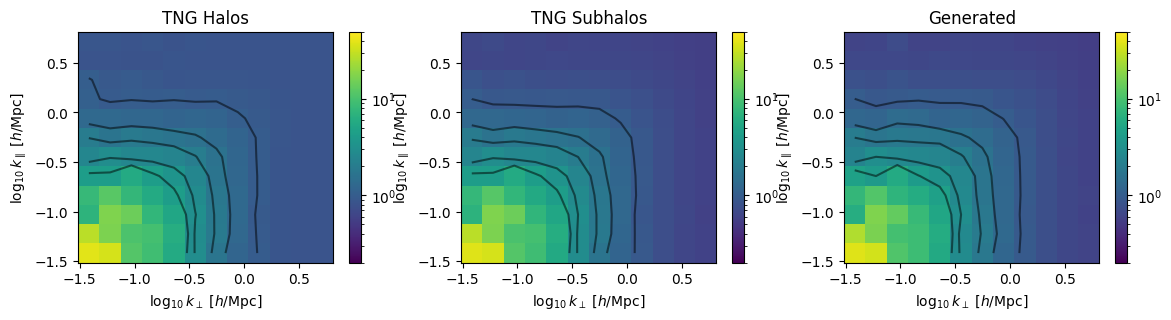

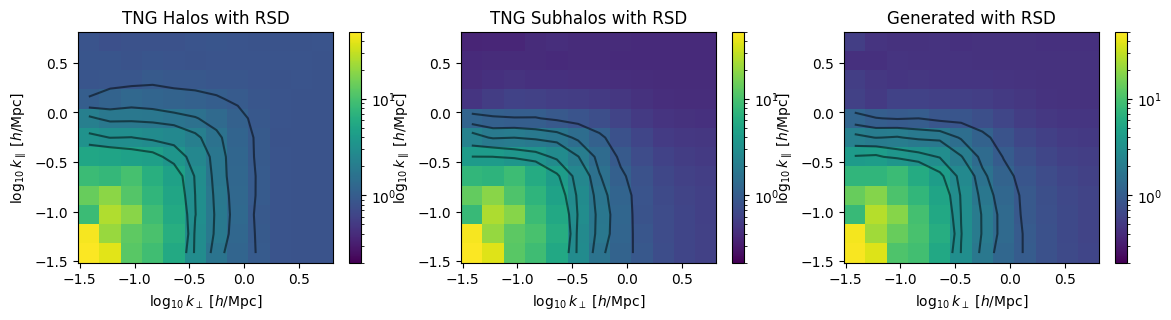

In [24]:
### Cylindrical power spectrum  
def plot_cylindrical_power(data_list, header_list, titles):
    ndata = len(data_list)
    plt.figure(figsize=(3*ndata, 3))
    plt.subplots_adjust(wspace=0.2)

    for i, (data, header) in enumerate(zip(data_list, header_list)):
        boxsize = header["boxsize"]
        power2d, k_perp, k_para, var = compute_cylindrical_power(data, boxlength=boxsize, nbins=12, log_bins=True, use_same_bins=True)
        
        log_k_perp = np.log10(k_perp)
        log_k_para = np.log10(k_para)

        ax = plt.subplot(1, ndata, i+1)
        plt.title(titles[i])

        vmin, vmax = None, None
        vmin, vmax = 0.2, 50
        plt.pcolormesh(log_k_perp, log_k_para, power2d, shading="auto", norm=LogNorm(vmin=vmin, vmax=vmax))
        plt.colorbar()

        log_k_perp_values = 0.5 * (log_k_perp[1:] + log_k_perp[:-1])
        log_k_para_values = 0.5 * (log_k_para[1:] + log_k_para[:-1])
        X, Y = np.meshgrid(log_k_perp_values, log_k_para_values)
        plt.contour(X, Y, power2d, levels=[1, 1.5, 2, 3, 4], colors="k", ls="dashed", alpha=0.5)

        plt.xlabel(r"$\log_{10} k_\perp \ [h/ \rm Mpc]$")
        plt.ylabel(r"$\log_{10} k_\parallel \ [h/ \rm Mpc]$")

        #plt.xlim(-1.51, 0)
        #plt.ylim(-1.51, 0)

        print(k_perp, k_para)

plot_cylindrical_power(data_list[:-1], header_list, titles)
plot_cylindrical_power(data_rsd_list[:-1], header_rsd_list, titles_rsd)

/tmp/ipykernel_666448/2908860347.py:7: RuntimeWarning: divide by zero encountered in log10
  value = np.log10(data).flatten()


Saved figure to ./output_test/figures/intensity_histogram.pdf


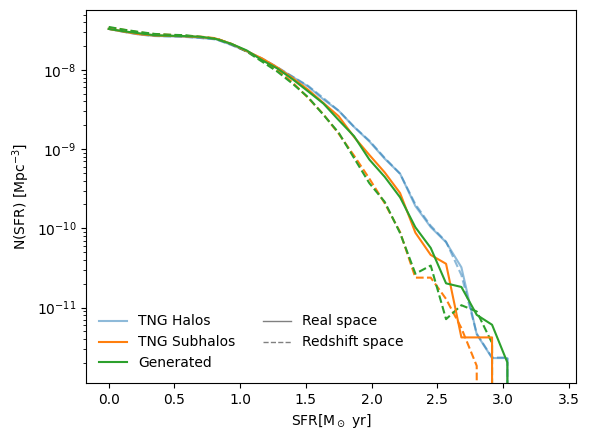

In [6]:
def plot_vid(data_list, header_list, titles, **kwargs):
    alpha = [0.5, 1, 1, 0.5, 1]
    for i, (data, header) in enumerate(zip(data_list, header_list)):
        boxsize = header["boxsize"] # Mpc/h
        #voxel_size = boxsize**3 / (data.shape[0] * data.shape[1] * data.shape[2])
        volume = (boxsize / hlittle) **3 
        value = np.log10(data).flatten()
        hist = np.histogram(value, bins=30, range=(0, 3.5), density=True)
        plt.plot(hist[1][:-1], hist[0]/volume, label=titles[i], color=colors[i], alpha=alpha[i], **kwargs)
        #plt.hist(value, range=(1, 3.5), bins=30, weights=np.ones_like(value/volume, histtype="step", label=titles[i])
        

plt.figure(figsize=(6, 4.5))
plot_vid(data_list[:3], header_list, titles)
plot_vid(data_rsd_list[:3], header_rsd_list, [None]*10, ls="--", zorder=-10)

plt.xlabel(r"${\rm SFR [M_\odot \ yr}]$")
plt.ylabel(r"$\rm N(SFR)\ [Mpc^{-3}]$")
plt.yscale("log")

xlim = plt.xlim()
ylim = plt.ylim()

plt.plot([0, 1], [ylim[0]*0.1, ylim[0]*0.1], color="gray", ls="solid", lw=1, label="Real space")
plt.plot([0, 1], [ylim[0]*0.1, ylim[0]*0.1], color="gray", ls="dashed", lw=1, label="Redshift space")
plt.xlim(xlim)
plt.ylim(ylim)

plt.legend(frameon=False, ncol=2)

fsave = "{}/figures/intensity_histogram.pdf".format(base_dir)
my_savefig(fsave)


The catalog is written in 1 file
reading header of file ./Pinocchio/my_test/output/pinocchio.2.0000.run1.catalog.out
This file has been written by 40 tasks
This is new output format, record length: 56
done with file ./Pinocchio/my_test/output/pinocchio.2.0000.run1.catalog.out
Reading catalog done, 23966139 groups found


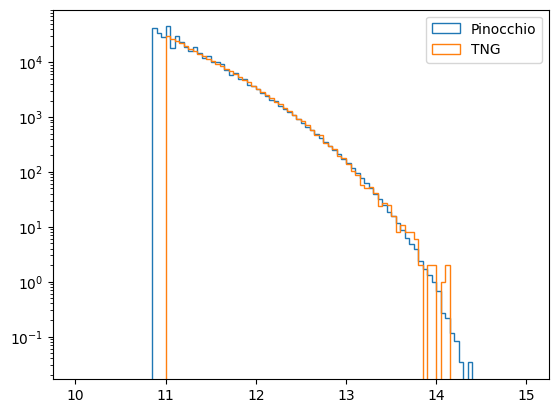

In [49]:
import Pinocchio.scripts.ReadPinocchio5 as rp
plt.figure()

irun = 1
input_fname = f"./Pinocchio/my_test/output/pinocchio.2.0000.run{irun}.catalog.out"    
mycat = rp.catalog(input_fname)

hlittle = cosmo.H(0).to(u.km/u.s/u.Mpc).value / 100.0 
factor = 0.8
logm = np.log10( mycat.data["Mass"] / hlittle * factor ) # [Msun]

volume_factor = (205 / 800)**3 * np.ones_like(logm)

plt.hist(logm, bins=100, range=[10, 15], histtype="step", label="Pinocchio", weights=volume_factor)

snapshot_number = 33
input_fname = f"./Transformer/TNG_data/group.{snapshot_number}.txt"
data = np.loadtxt(input_fname)
logm = data[:, 0]

# histogram of logm
plt.hist(logm, bins=100, range=[10, 15], histtype="step", label="TNG") #, density=True)

plt.legend()
plt.yscale("log")